# Fine Tuning GPT-2 for Safeguarding text generation.
---

Looking to fine-tune GPT2 in order to generate synthetic safeguarding data that would otherwise be difficult to source. The context is for a custom keyboard - so the classifier would be looking at short messages being written by a user to send on a messaging/social media platofrm. The messages will be short - one or two sentences. 

This Notebook is based on work by Richard Bownes who described fine-tuning to generate text int he style of the card game Magic The Gathering. https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93

This Notebook uses [PyTorch](https://pytorch.org/) and Transformers from [Hugging Face](https://huggingface.co/) to fine tune a [GPT-2 Model](https://openai.com/blog/gpt-2-1-5b-release/) that will generate messages based on a small set of example messages


This Notebook only slightly varies from Richard's one, all credit to him.
---

 Here are his credits:


I've borrowed heavily from those who came before me for inspiration and code chunks for this notebook, please check out [Rey Farhan](http://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/), who in turn heavily cites [Chris McCormick's](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) BERT fine-tuning tutorial, [Ian Porter's](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) GPT2 tutorial and the [Hugging Face](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) Language model fine-tuning script.

By the end of this tutorial you should be able to quickly and easily fine tune your own language model for generative tasks and have a decent understanding of the levers you can adjust to parameterize the model!


# Setup

We will be fine tuning an existing GPT2 model using the interface Hugging Face provides. Fine tuning instead of retraining for a few very simple and pragmatic reasons. First among them these language models requre vast swaths of data and are computationally prohibitively expensive to train. However, by leveraging what is already available we can cut out both of these requirements. This means we can tweak the outputs of the model to suit specific purposes with minimal data and with achievable hardward. This is essentially transfer learning for language generation problems. To start off with we need to install the Huggingface transformers library first. Many of the common scientific libraries are pre-installed on Colab but not this one in particular. Installing transformers will also install tokenizers, a dependency, and another useful set of tools for this task.

In [32]:
%%capture
!pip install transformers

# Create Training Set

We're going to use the flavor text of existing MTG cards to generate new ones. Luckily, the hard work of scraping the data has been done for us and we can ingest the flavor text from the [Scryfall](https://scryfall.com/advanced) API and quickly parson the json we are returned. 


In [52]:
# We'll need these libraries to gather and shape the data.
import requests 
import pandas as pd
from itertools import compress

# This will return the data for all the cards available to scryfall.
r = requests.get('https://raw.githubusercontent.com/swingpants/gpt2generator/main/Suicide_Data_BBC_Generated.json')
data = r.json()

# we'll start parsing by removing any cards with no flavor text
#contains_x = []
#for i in data:
    #print (i['message'])

    #contains_x.append('message' in i.keys())

#data_filtered = list(compress(data, contains_x))

# next we'll remove any cards in a language other than english
#contains_y = []
#for i in data_filtered:
#  contains_y.append('lang' in i.keys() and 'en' == i['lang'])

#data_filtered = list(compress(data_filtered, contains_y))

# Now we'll create a list to iterate through.
cardValues = []
for i in data:
    cardValues.append(i['message'])

# I'll convert this to a data frame to visualize a few rows nicely
# mostly just a sanity check.
df = pd.DataFrame(
    cardValues,
    columns=['data']
    )

cards = df.data.copy()
cards

0                                   it was a cry for help
1                              A friend attempted suicide
2                              A relative died by suicide
3                            My teacher attempted suicide
4                 i know someone who has comitted suicide
                              ...                        
1081    i'm so upset about the way things are, i want ...
1082                     it was my way of killing myself.
1083    don't want to be alive again, no longer want t...
1084            I feel like a child again, i want to die.
1085               why am i thinking about killing myself
Name: data, Length: 1086, dtype: object

# GPT2 Tokenizer

First a brief description of tokenization straight from the source, the Hugging Face [Tokenizers](https://github.com/huggingface/tokenizers) github page:

```
What is a Tokenizer

A Tokenizer works as a pipeline, it processes some raw text as input and outputs an Encoding. The various steps of the pipeline are:

- The Normalizer: in charge of normalizing the text. Common examples of normalization are the unicode normalization standards, such as NFD or NFKC.
- The PreTokenizer: in charge of creating initial words splits in the text. The most common way of splitting text is simply on whitespace.
- The Model: in charge of doing the actual tokenization. An example of a Model would be BPE or WordPiece.
- The PostProcessor: in charge of post-processing the Encoding to add anything relevant that, for example, a language model would need, such as special tokens.
```

We will be using the GPT-2 tokenizer to tokenize our flavor text data. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' but we can specifically set them differently to differentiate and also assign a non-default pad token that will take care of white space for differently sized text. The next cell will instantiate our tokenizer and provide an example encoding.

In [53]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


[36674, 8255]

From the example above we can see that the example string is encoded by the GPT2 tokenizer to a list of numerical values that represent the string, in this case one value per word. These values are easier to train the neural network model on than the string representation. We now have a corpus of flavour text we can iterate through, and a tokenizer, we should quickly inspect it to see what the longest string is, this will be useful later when we need to know how long to pad our sentences out to.


In [54]:
max_message = max([len(tokenizer.encode(card)) for card in cards])

print(f'The longest message text is {max_message} tokens long.')

The longest message text is 36 tokens long.


# PyTorch Datasets & Dataloaders


Different language models require different amounts of memory to hold all of the weights and biases in memory. Based on the memory your machine has available this will determine how you set your batch size. If your instance is running on a T4 GPU you can set batch to 32, but you may have to scale down if allocated a less powerful instance. 

In [55]:
!nvidia-smi

Thu Oct 15 16:34:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W /  70W |  15021MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
bs = 32

The batch size will affect the training time so it is always a good idea to set the batch to the highest number you can fit in the memory of the GPU you are using for training, however this hyper parameter should only affect training time but not model performance. A batch size too large won't fit in memory for some GPUS so you will have to adjust this parameter if you aren't allocated a T4 or K80.

The next thing to do is to create a custom dataloader for our corpus, we will follow the [PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) documentation on this to create ```MTGDataset```.

In [57]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class MTGDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_message):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the flavour text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

The maximum length of tokens is 768, however we don't need to use this length as we saw that the longest string we are encoding is only 98 words long. So to save space in the model we will only pad up to the longest string in our corpus and not the longest string the tokenizer can handle. Next we will create the dataset itself using this class. Like I described above in the code each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask. This dataset will then be split into the training and validation sets.


In [58]:
from torch.utils.data import random_split

dataset = MTGDataset(cards, tokenizer, max_length=max_message)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 977 samples for training, and 109 samples for validation testing'

Finally to illustrate what an entry in this dataset looks like below is a print out of the first encoded string. You can see that for every encoded word the model pays attention to we have a 1, then for the padding encodings (50258) we have a 0.

In [59]:
dataset[0]

(tensor([50257,   270,   373,   257,  3960,   329,  1037, 50256, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset, see the official [documentation](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html) for further details. 

In [60]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [61]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [62]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 8
warmup_steps = 1e2
sample_every = 10

[AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) is the optimizer of choice for training many models, we will be using [Hugging Face's](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models. 

In [63]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [64]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [65]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:9.988722801208496. Time:0:00:03
Example output:  bipartisan the and


The Department of administration Department of the Department The Department of the
 Department The

The Department The
 Department of the
 Department of the

The Department of the
 Department of the

The Department The

The Department The

The Department The

The Department The

The Department The
 The



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:2.2590420246124268. Time:0:00:10
Example output:  increasing by
 TheOathI.meMyMyTheAnas.me


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:1.4388821125030518. Time:0:00:13
Example output: dayi they he i c.

(A)
Average Training Loss: 10.233918347666341. Epoch time: 0:00:13
Validation loss: 1.3695759177207947. Validation Time: 0:00:00
Beginning epoch 2 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:1.1224980354309082. Time:0:00:03
Example output:  Hangam now.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:0.8547739386558533. Time:0:00:07
Example output:  foods- forgive me back!


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:0.9656436443328857. Time:0:00:10
Example output:  trailmy friend was living in shock
Average Training Loss: 1.0885881743123453. Epoch time: 0:00:10
Validation loss: 0.7655598074197769. Validation Time: 0:00:00
Beginning epoch 3 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:0.8009207248687744. Time:0:00:03
Example output: intendI'm a doctor, and my friend died.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:0.6664159893989563. Time:0:00:07
Example output:  surroundi tried to kill myself by shooting myself in the head.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:0.7052015066146851. Time:0:00:11
Example output:  reflexi need to go to the doctor?
Average Training Loss: 0.7595902950532974. Epoch time: 0:00:11
Validation loss: 0.6763601452112198. Validation Time: 0:00:00
Beginning epoch 4 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:0.7618911266326904. Time:0:00:04
Example output:  displayi want to die today.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:0.5126498341560364. Time:0:00:07
Example output:  pastorI have a debilitating illness with a horrible disease, and it isn't worth it.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:0.560675859451294. Time:0:00:11
Example output:  illiciti have failed to live.
Average Training Loss: 0.6808853418596329. Epoch time: 0:00:11
Validation loss: 0.6335223615169525. Validation Time: 0:00:00
Beginning epoch 5 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:0.5678204894065857. Time:0:00:04
Example output:  Liberationi think that i'm going to burn my own fucking head.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:0.5319440364837646. Time:0:00:07
Example output:  Nama kid who really wants to die.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:0.5954341888427734. Time:0:00:11
Example output: IONmy friend killed himself in school suicide
Average Training Loss: 0.5899087373287447. Epoch time: 0:00:11
Validation loss: 0.605212077498436. Validation Time: 0:00:00
Beginning epoch 6 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:0.5900803804397583. Time:0:00:04
Example output:  glimpsei'm killing myself because i'm going to use a belt to stop the urge.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:0.5301708579063416. Time:0:00:07
Example output:  Laurei'm going to end this note.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:0.5025184154510498. Time:0:00:11
Example output: ismi am sick of living, i want to kill myself
Average Training Loss: 0.540328614173397. Epoch time: 0:00:11
Validation loss: 0.5954586267471313. Validation Time: 0:00:00
Beginning epoch 7 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:0.5181289315223694. Time:0:00:04
Example output: ouni am doing nothing for myself


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:0.5413849949836731. Time:0:00:07
Example output:  electioni think about killing myself


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:0.5848954319953918. Time:0:00:11
Example output:  crazya friend killed herself
Average Training Loss: 0.5121787584597065. Epoch time: 0:00:11
Validation loss: 0.5913398414850235. Validation Time: 0:00:00
Beginning epoch 8 of 8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 10 of 31. Loss:0.5049205422401428. Time:0:00:04
Example output:  benchi have had my own problems with drugs, and they're ruining my life.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 20 of 31. Loss:0.4547172784805298. Time:0:00:07
Example output:  incorporatedi want to die without joy.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 30 of 31. Loss:0.4370369017124176. Time:0:00:11
Example output: PeterI'm not a doctor or a friend of mine, suicide isn't the answer.
Average Training Loss: 0.4854657323129715. Epoch time: 0:00:12
Validation loss: 0.5936405807733536. Validation Time: 0:00:00
Total training took 0:01:33


Let's view the summary of the training process, We'll visualize the change in training and validation loss to see if the models is converging. 

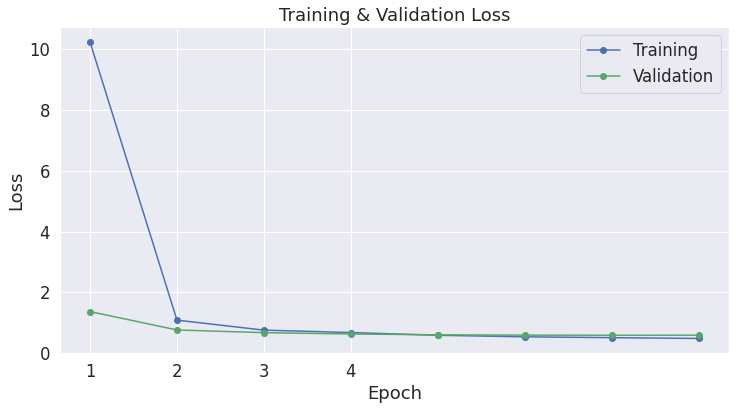

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Saving & Loading Fine-Tuned Model

Next it is a good idea to move the model we have trained and the associated weights, biases and model parameters out of the Colab space and into our own google drives. The cell below will mount your drive for you, then you can save the model using the prebuilt Hugging Face and PyTorch functionalities.




In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import os

output_dir = '/content/drive/My Drive/SafeguardingGPT2'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
args={}
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Generate Text

Lastly the fun part! We will now generate samples from our model to test how well our model performs!

In [77]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 400,
                                top_p=0.95, 
                                num_return_sequences=300
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0: i'm taking pills right now, i want to end it


1: my sister committed suicide.


2: i know i want to die, i want to die, i want to end it.


3: i want to die, and my friends tell me to jump out of my window, and I'll cut my wrists.


4: is that suicide?


5: A friend attempted suicide at my school, but my teacher was very caring.


6: I want to die.


7: i am going to kill myself without pain.


8: is a successful suicide victim.


9: my friend lost her life.


10: he left me alone


11: i really wanted to end it all with a smile and a small talk


12: i feel like a victim of suicide.


13: I don't want to live anymore, or i want to kill myself


14: i want to die slowly, right now.


15: I have tried to kill myself.


16: it hurts when i am depressed and alone.


17: i tried to kill myself


18: i'm going to kill myself with the belt.


19: Suicide is my answer, I don't want to live anymore.


20: why did i suicide because of my own freaking stupidity?


21: i tried to end it all.


If you are familiar with MTG then you can evaluate these for yourself to determine how well the model has worked, or if you have modified the code to accept your own data input for a specific task this is what you are looking to evaluate for your own uses. Lastly, if you want to load the model you have saved to your google drive, the next cell will load the fine tuned GPT2 model and tokenizer, this means you can also share your model with other!

In [ ]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)